In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

import pathlib as pth

import wandb
from torchvision.datasets import CIFAR10, MNIST, QMNIST, USPS
from torchvision import transforms
import torch
import torch.nn as nn
from torch.distributions import Bernoulli
from easydict import EasyDict
import torchshow as ts

import os
import sys
os.chdir('../')
sys.path.append("../")
print(sys.path)

from scae.models.pcae import PCAE
from scae.modules.part_capsule_ae import TemplateImageDecoder
# from scae.args import parse_args

import scae.util.math as math_utils
from scae.util.vis import plot_image_tensor_2D, plot_image_tensor
from scae.util.wandb import to_wandb_im

['/home/axquaris/StackedCapsuleAutoencoders/notebooks', '/home/axquaris/.conda/envs/crystalize/lib/python37.zip', '/home/axquaris/.conda/envs/crystalize/lib/python3.7', '/home/axquaris/.conda/envs/crystalize/lib/python3.7/lib-dynload', '', '/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages', '/home/axquaris/Crystalize/submodules/invertible-resnet', '/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages/IPython/extensions', '/home/axquaris/.ipython', '../']


In [2]:
from torchvision.datasets import MNIST
t = transforms.Compose([
#     transforms.RandomCrop([40, 40], pad_if_needed=True),
    transforms.ToTensor(),
    # norm_1c
])
mnist = MNIST('data/mnist', train=False, transform=t, download=True)

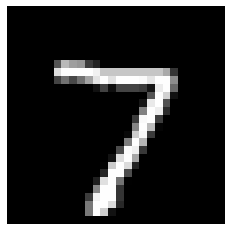

In [3]:
import torchshow as ts
from IPython.display import HTML
video_tensor = torch.cat([mnist[i][0] for i in range(10)], dim=0)
ani = ts.show_video(video_tensor, show=False)
HTML(ani.to_jshtml())

In [4]:
from scae.data.mnist_objects import MNISTObjects
macaroni_dataset = MNISTObjects(template_mixing='max', template_src='mlatberkeley/StackedCapsuleAutoEncoders/67lzaiyq', num_caps=4, new=True, size=100)

NameError: name 'self' is not defined

In [8]:
n_frames = 60

# trans_xs, trans_ys, scale_xs, scale_ys, thetas, shears
# trans_xs, trans_ys, scale, thetas (similar transforms)
pose_tensors = [[] for _ in range(4)]

def lerp(v_min, v_max, i, tot=n_frames):
    v_min = torch.as_tensor(v_min)
    v_max = torch.as_tensor(v_max)
    return (v_min + (v_max - v_min) * i / tot).tolist()
    
for i in range(n_frames):
    pose_tensors[0].append(lerp([-1, 0, 1, 1, 0, 0],
                             [1, 0, 1, 1, 0, 0],i))
    pose_tensors[1].append(lerp([0, -1, 1, .8, 0, 0],
                             [0, 1, 1, .8, 0, 0],i))
    pose_tensors[2].append(lerp([0, 0, .5, 1, 0, 0],
                             [0, 0, 2, 1, 0, 0],i))
    pose_tensors[3].append(lerp([0, 0, 1, 1, 0, 0],
                             [0, 0, 1, 1, 3.14*2, 0],i))
pose_tensors = torch.as_tensor(pose_tensors, device='cuda')
print(pose_tensors.shape)

torch.Size([4, 60, 6])


In [9]:
def T(images, poses, target_res, inverse=True):
    images_flat = images.reshape(-1, *images.shape[-3:]).cuda()
    
    transformed_shape = (*poses.shape[:-1], 1, *target_res)
    transformed_shape_flat = (images_flat.shape[0], 1, *target_res)
    
    # trans_xs, trans_ys, scale_xs, scale_ys, thetas, shears ==> 2x3 sample coord transform matrix
    poses = math_utils.geometric_transform(poses, similarity=True, nonlinear=False, as_matrix=False, inverse=inverse).reshape(*poses.shape[:-1], 2, 3)

    grid_coords_flat = nn.functional.affine_grid(theta=poses.view(-1, 2, 3), size=transformed_shape_flat)
    
    transformed_images_flat = nn.functional.grid_sample(images_flat, grid_coords_flat)
    return transformed_images_flat.view(transformed_shape)

/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


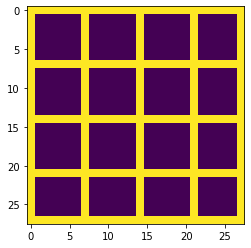

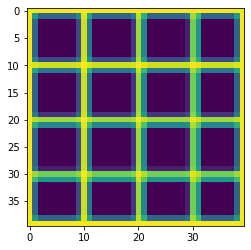

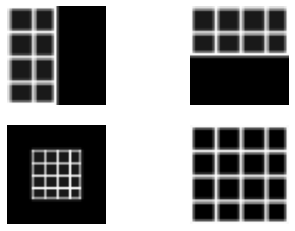

<Figure size 1332x756 with 0 Axes>

In [10]:
template = torch.ones_like(mnist[i][0]).cuda() * .1
template[:, ::7, :] = 1
template[:, :, ::7] = 1
template[:, -1, :] = 1
template[:, :, -1] = 1

target_res = (40, 40)

template_stack = template.repeat(*pose_tensors.shape[:-1], 1, 1, 1)

video_tensor = T(template_stack.cuda(), pose_tensors.cuda(), target_res)

plt.imshow(template.cpu().permute(1,2,0))
plt.show()
plt.imshow(video_tensor[-1][0].cpu().permute(1,2,0))
plt.show()

out = list(video_tensor)
ani = ts.show_video([out[:2], out[2:]], show=False)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ani.save("notebooks/transforms.gif")
HTML(ani.to_jshtml())

/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


torch.Size([2, 40, 3, 140, 140])


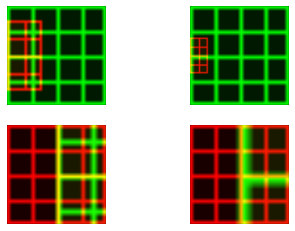

<Figure size 1332x756 with 0 Axes>

In [13]:
target_res = (140, 140)
n_frames = 40

# trans_xs, trans_ys, scale_xs, scale_ys, thetas, shears
# trans_xs, trans_ys, scale, thetas (similar transforms)
pose_tensors = [[] for _ in range(2)]

def lerp(v_min, v_max, i, tot=n_frames):
    v_min = torch.as_tensor(v_min)
    v_max = torch.as_tensor(v_max)
    return (v_min + (v_max - v_min) * i / tot).tolist()
    
for i in range(n_frames):
    scale = 28./40
    rot = 0
    pose_tensors[0].append(lerp([-1, 0, scale, 0, rot, 0], [1, 0, scale, 0, 3.1416, 0], i))
    pose_tensors[1].append(lerp([-1, 0, scale/2, 0, rot, 0], [1, 0, scale*2, 0, rot, 0], i))
pose_tensors = torch.as_tensor(pose_tensors, device='cuda')

template_stack = template.repeat(*pose_tensors.shape[:-1], 1, 1, 1)

transformed_tensor = T(template_stack.cuda(), pose_tensors.cuda(), target_res)
transformed_tensor_inv = T(template_stack.cuda(), pose_tensors.cuda(), target_res, inverse=False)


template_target = T(template, torch.tensor([0., 0., 1., 1., 0., 0.]).cuda(), target_res)

video_tensor = torch.zeros_like(transformed_tensor).repeat(1, 1, 3, 1, 1)
print(video_tensor.shape)
video_tensor[:, :, 2] = template_target
video_tensor[:, :, 0] = transformed_tensor[:, :, 0]

video_tensor_inv = torch.zeros_like(transformed_tensor_inv).repeat(1, 1, 3, 1, 1)
video_tensor_inv[:, :, 0] = template_target
video_tensor_inv[:, :, 2] = transformed_tensor_inv[:, :, 0]


ani = ts.show_video([list(video_tensor), list(video_tensor_inv)], show=False)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ani.save("notebooks/transforms.gif")
HTML(ani.to_jshtml())

In [ ]:
import wandb

In [ ]:
wandb.init(reinit=True, id="asdf")

In [ ]:
wandb.log({"animation": wandb.Image(a)})